In [25]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
from tensorflow.keras.applications.vgg16 import VGG16

In [26]:
# ==========================
# CONFIG
# ==========================
DATASET_PATH = "/kaggle/input/dataset"  # Kaggle dataset name
SIZE = 256  # Resize all images
TEST_SPLIT = 0.2  # 80% train, 20% test

In [27]:
# ==========================
# LOAD ALL IMAGES & LABELS
# ==========================
images = []
labels = []

for directory_path in glob.glob(os.path.join(DATASET_PATH, "*")):
    if not os.path.isdir(directory_path):
        continue
    label = os.path.basename(directory_path)  # class name
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            continue
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        labels.append(label)

images = np.array(images)
labels = np.array(labels)

In [28]:
# ==========================
# ENCODE LABELS
# ==========================
le = preprocessing.LabelEncoder()
labels_encoded = le.fit_transform(labels)


In [29]:
# ==========================
# SPLIT DATA
# ==========================
x_train, x_test, y_train, y_test = train_test_split(
    images, labels_encoded,
    test_size=TEST_SPLIT,
    stratify=labels_encoded,
    random_state=42
)

In [30]:
# ==========================
# NORMALIZE
# ==========================
x_train = x_train / 255.0
x_test = x_test / 255.0

In [31]:
# ==========================
# VGG16 FEATURE EXTRACTION
# ==========================
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
for layer in VGG_model.layers:
    layer.trainable = False

print("Extracting features with VGG16...")
X_train_features = VGG_model.predict(x_train, verbose=1)
X_train_features = X_train_features.reshape(X_train_features.shape[0], -1)

X_test_features = VGG_model.predict(x_test, verbose=1)
X_test_features = X_test_features.reshape(X_test_features.shape[0], -1)

Extracting features with VGG16...
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 300ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step


In [32]:
# ==========================
# TRAIN XGBOOST
# ==========================
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),
    eval_metric='mlogloss'
)
xgb_model.fit(X_train_features, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)

In [33]:
# ==========================
# PREDICT
# ==========================
predictions = xgb_model.predict(X_test_features)

In [34]:
# ==========================
# ERROR ANALYSIS
# ==========================
accuracy = metrics.accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average=None)
recall = recall_score(y_test, predictions, average=None)
f1 = f1_score(y_test, predictions, average=None)

print("\n===== Overall Metrics =====")
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro Precision: {precision_score(y_test, predictions, average='macro'):.4f}")
print(f"Macro Recall: {recall_score(y_test, predictions, average='macro'):.4f}")
print(f"Macro F1-score: {f1_score(y_test, predictions, average='macro'):.4f}")
print(f"Weighted Precision: {precision_score(y_test, predictions, average='weighted'):.4f}")
print(f"Weighted Recall: {recall_score(y_test, predictions, average='weighted'):.4f}")
print(f"Weighted F1-score: {f1_score(y_test, predictions, average='weighted'):.4f}")

print("\n===== Classification Report =====")
print(classification_report(y_test, predictions, target_names=le.classes_))


===== Overall Metrics =====
Accuracy: 0.7692
Macro Precision: 0.7775
Macro Recall: 0.7693
Macro F1-score: 0.7680
Weighted Precision: 0.7745
Weighted Recall: 0.7692
Weighted F1-score: 0.7665

===== Classification Report =====
              precision    recall  f1-score   support

         cat       0.75      0.86      0.80        21
         cow       0.79      0.55      0.65        20
         dog       0.76      0.76      0.76        21
        lamb       0.64      0.73      0.68        22
       zebra       0.95      0.95      0.95        20

    accuracy                           0.77       104
   macro avg       0.78      0.77      0.77       104
weighted avg       0.77      0.77      0.77       104



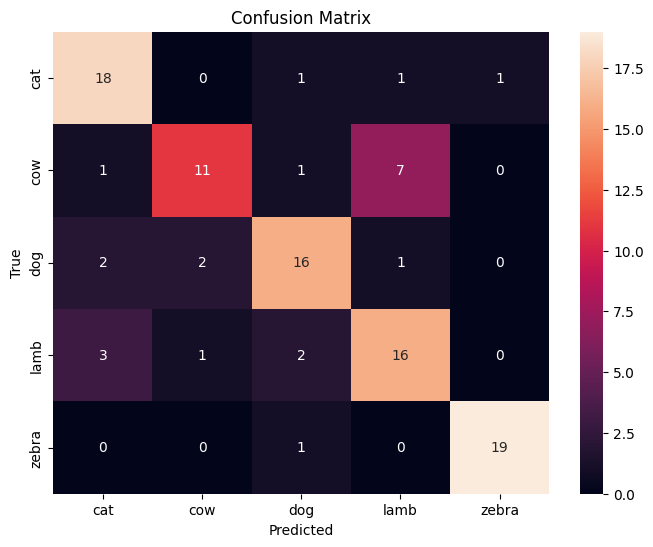

In [35]:
# Confusion Matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
Prediction: cow
Actual: cow


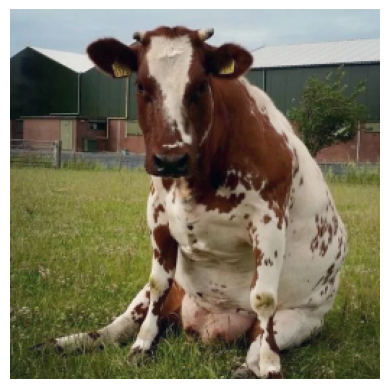

In [36]:
# ==========================
# TEST RANDOM IMAGE
# ==========================
n = np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
plt.axis("off")
input_img = np.expand_dims(img, axis=0)
input_features = VGG_model.predict(input_img)
input_features = input_features.reshape(input_features.shape[0], -1)
pred_class = xgb_model.predict(input_features)[0]
pred_label = le.inverse_transform([pred_class])[0]

print("Prediction:", pred_label)
print("Actual:", le.inverse_transform([y_test[n]])[0])